In [1]:
import os
import gc
import sys
import time
import h5py
import torch
import numpy as np
import pandas as pd
from numpy.lib.function_base import corrcoef
import nibabel as nib
from nilearn import image, surface, plotting, datasets

from sklearn.metrics import pairwise_distances
import scipy.sparse as sps
import scipy as sp
from scipy.sparse.linalg import eigsh, eigs
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

from scipy import stats
from scipy.stats import pearsonr

from matplotlib import font_manager
font_manager.fontManager.addfont("/n02dat01/users/lchai/anaconda3/envs/Nm/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/arial.ttf")
plt.rcParams["font.sans-serif"] = "Arial" 

/n01dat01/dyli/soft/miniconda3/envs/pynb/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
# read the basic info
dirc_L = '/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = '/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

In [3]:
def procrustes(source, target, center=False, scale=False):
    """Align `source` to `target` using procrustes analysis.

    Parameters
    ----------
    source : 2D ndarray, shape = (n_samples, n_feat)
        Source dataset.
    target : 2D ndarray, shape = (n_samples, n_feat)
        Target dataset.
    center : bool, optional
        Center data before alignment. Default is False.
    scale : bool, optional
        Remove scale before alignment. Default is False.

    Returns
    -------
    aligned : 2D ndarray, shape = (n_samples, n_feat)
        Source dataset aligned to target dataset.
    """

    # Translate to origin
    if center:
        ms = source.mean(axis=0)
        mt = target.mean(axis=0)

        source = source - ms
        target = target - mt

    # Remove scale
    if scale:
        ns = np.linalg.norm(source)
        nt = np.linalg.norm(target)
        source /= ns
        target /= nt

    # orthogonal transformation: rotation + reflection
    u, w, vt = np.linalg.svd(target.T.dot(source).T)
    t = u.dot(vt)

    # Recover target scale
    if scale:
        t *= w.sum() * nt

    # print(t)
    aligned = source.dot(t)
    if center:
        aligned += mt
    return aligned

# HCP twins

In [4]:
# 读取梯度数据
emb_L = np.load('/n01dat01/dyli/data4n02/HCP_twins_sparse90_embedding_dense_emb_L.npy')
emb_R = np.load('/n01dat01/dyli/data4n02/HCP_twins_sparse90_embedding_dense_emb_R.npy')
print(emb_L.shape, emb_R.shape, min(emb_L.shape[1], emb_R.shape[1]))
number = 10
emb_L = emb_L[:, 0:number]
emb_R = emb_R[:, 0:number]

(29696, 23) (29716, 21) 21


In [10]:
indi_father = '/n01dat01/dyli/data4n02/HCP_twin'

name_path = './HCP_twins.txt'
with open( name_path, 'r' ) as f:
    namelist = [ str( line.strip()) for line in f.readlines() ]
print(len(namelist))
rm_list = ['552544','126931','745555','116120','150423','179548','149741','395958','142626','198855','128329','107422']
print(len(rm_list))
namelist_new = namelist
for _ in rm_list:
    namelist_new.remove(_)
print(len(namelist_new))

for sub in tqdm(namelist_new):
    indi_L = np.load(f'{indi_father}/{sub}/{sub}_embedding_dense_emb_L_zeros_vertex_new.npy')
    indi_R = np.load(f'{indi_father}/{sub}/{sub}_embedding_dense_emb_R_zeros_vertex_new.npy')

    assert indi_L.shape[1] >= number and indi_R.shape[1] >= number

    indi_L_new = procrustes(indi_L[:, 0:number], emb_L)
    indi_R_new = procrustes(indi_R[:, 0:number], emb_R)

    np.save(f'/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/twin_{sub}_emb_L.npy', indi_L_new)
    np.save(f'/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/twin_{sub}_emb_R.npy', indi_R_new)

194
12
182


100%|██████████| 182/182 [00:09<00:00, 18.62it/s]


# HCP unrelated

* read the group GCs

In [5]:
# 读取梯度数据
emb_L = np.load('/n02dat01/users/dyli/Grad_data/sc/MPC_Grad_results/MPC_sc_vertex_volume_100_embedding_dense_emb_L_zeros.npy')
emb_R = np.load('/n02dat01/users/dyli/Grad_data/sc/MPC_Grad_results/MPC_sc_vertex_volume_100_embedding_dense_emb_R_zeros.npy')
print(emb_L.shape, emb_R.shape, min(emb_L.shape[1], emb_R.shape[1]))
number = 20
emb_L = emb_L[:, 0:number]
emb_R = emb_R[:, 0:number]

(29696, 23) (29716, 21) 21


* individual GCs align to the group GCs

In [ ]:
indi_father = '/n02dat01/users/dyli/Grad_data/n04_data/Grad_tmp/sc_MPC_grad_indi/emb'

list_path = f'/n02dat01/users/dyli/Grad_data/support_data/HCP_U100_list.txt'
with open( list_path, 'r' ) as f:
    namelist = [ str( line.strip()) for line in f.readlines() ]
print(len(namelist))

for sub in tqdm(namelist):
    indi_L = np.load(f'{indi_father}/{sub}_MPC_sc_embedding_dense_emb_L.npy')
    indi_R = np.load(f'{indi_father}/{sub}_MPC_sc_embedding_dense_emb_R.npy')

    assert indi_L.shape[1] >= number and indi_R.shape[1] >= number

    indi_L_new = procrustes(indi_L[:, 0:number], emb_L)
    indi_R_new = procrustes(indi_R[:, 0:number], emb_R)

    np.save(f'/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/{sub}_emb_L.npy', indi_L_new)
    np.save(f'/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/{sub}_emb_R.npy', indi_R_new)

* plotting the correlation between the individual GCs and the group GCs

In [ ]:
for sub in namelist:
    # calculate the correlation between the original individual GCs and the group GCs
    indi_L = np.load(f'{indi_father}/{sub}_MPC_sc_embedding_dense_emb_L.npy')
    indi_R = np.load(f'{indi_father}/{sub}_MPC_sc_embedding_dense_emb_R.npy')
    r = np.corrcoef(indi_L[:, 0:number].T, emb_L[:, 0:number].T)[0:number,:][:,number:]
    f, ax= plt.subplots(figsize = (6, 5))
    fig = sns.heatmap(r, cmap='RdBu_r', cbar=False)
    plt.xticks([])
    plt.yticks([])
    cb = fig.figure.colorbar(fig.collections[0]) #显示colorbar
    cb.ax.tick_params(labelsize=15) #设置colorbar刻度字体大小
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha = 'right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha = 'right')
    fig = fig.get_figure()
    plt.title(f'{sub}', fontsize=20)
    fig.savefig(f'/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/ori_indi_corr_plot/{sub}_L.png', transparent = True, bbox_inches = 'tight',dpi = 700, format='png')
    plt.show()

/n01dat01/dyli/soft/miniconda3/envs/pynb/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


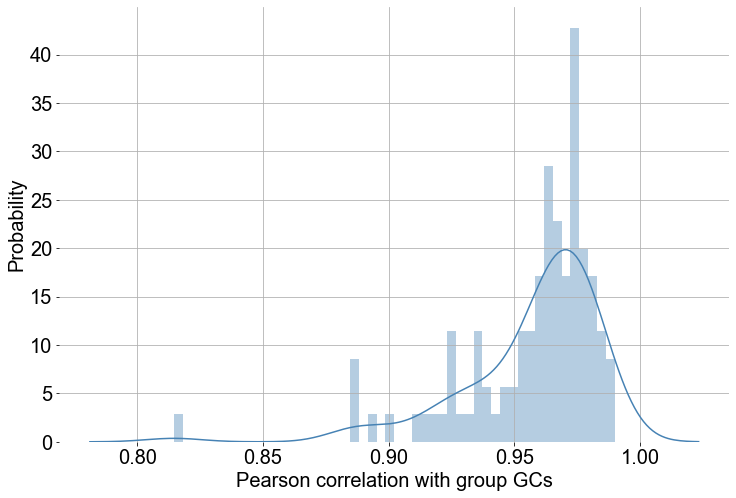

/n01dat01/dyli/soft/miniconda3/envs/pynb/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


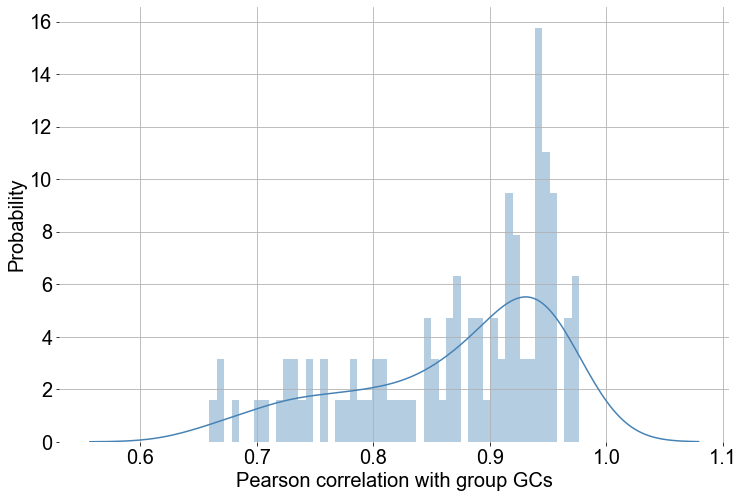

/n01dat01/dyli/soft/miniconda3/envs/pynb/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


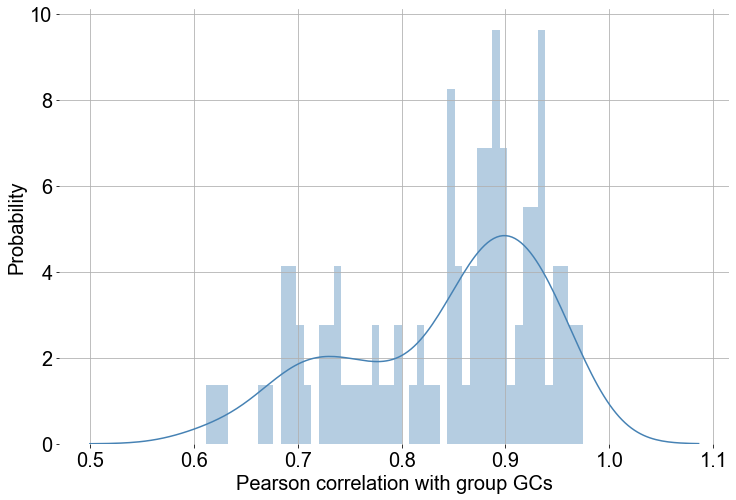

In [18]:
number = 3
r1 = np.zeros(len(namelist))
r2 = np.zeros(len(namelist))
r3 = np.zeros(len(namelist))
for subi,sub in enumerate(namelist):
    # calculate the correlation between the original individual GCs and the group GCs
    indi_L = np.load(f'/n02dat01/users/dyli/Grad_data/n04_data/Grad_tmp/sc_MPC_grad_indi/emb/{sub}_MPC_sc_embedding_dense_emb_L.npy')
    indi_R = np.load(f'/n02dat01/users/dyli/Grad_data/n04_data/Grad_tmp/sc_MPC_grad_indi/emb/{sub}_MPC_sc_embedding_dense_emb_R.npy')
    r1[subi] = np.corrcoef(indi_L[:, 0:number].T, emb_L[:, 0:number].T)[0:number,:][:,number:][0,0]
    # GC2 and GC3
    if np.abs(np.corrcoef(indi_L[:, 0:number].T, emb_L[:, 0:number].T)[0:number,:][:,number:][1,1]) < np.abs(np.corrcoef(indi_L[:, 0:number].T, emb_L[:, 0:number].T)[0:number,:][:,number:][1,2]):
        r2[subi] = np.corrcoef(indi_L[:, 0:number].T, emb_L[:, 0:number].T)[0:number,:][:,number:][1,2]
        r3[subi] = np.corrcoef(indi_L[:, 0:number].T, emb_L[:, 0:number].T)[0:number,:][:,number:][2,1]
    else:
        r2[subi] = np.corrcoef(indi_L[:, 0:number].T, emb_L[:, 0:number].T)[0:number,:][:,number:][1,1]
        r3[subi] = np.corrcoef(indi_L[:, 0:number].T, emb_L[:, 0:number].T)[0:number,:][:,number:][2,2]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))  #设置画布的大小
sns.set_palette("hls")       #设置所有图的颜色，使用hls色彩空间
sns.distplot(np.abs(r1),color="steelblue",bins=50)
plt.xlabel('Pearson correlation with group GCs',fontsize=20)           #添加x轴标签，并改变字体
plt.ylabel('Probability',fontsize=20)   #添加y轴变浅，并改变字体
plt.grid(linestyle='-')   #添加网格线
plt.xticks(fontsize=20)   #改变x轴字体大小
plt.yticks(fontsize=20)   #改变y轴字体大小
sns.despine(ax=None, top=True, right=True, left=True,bottom=True)    #将图像的框框删掉
plt.show()

plt.figure(figsize=(12, 8))  #设置画布的大小
sns.set_palette("hls")       #设置所有图的颜色，使用hls色彩空间
sns.distplot(np.abs(r2),color="steelblue",bins=50)
plt.xlabel('Pearson correlation with group GCs',fontsize=20)           #添加x轴标签，并改变字体
plt.ylabel('Probability',fontsize=20)   #添加y轴变浅，并改变字体
plt.grid(linestyle='-')   #添加网格线
plt.xticks(fontsize=20)   #改变x轴字体大小
plt.yticks(fontsize=20)   #改变y轴字体大小
sns.despine(ax=None, top=True, right=True, left=True,bottom=True)    #将图像的框框删掉
plt.show()

plt.figure(figsize=(12, 8))  #设置画布的大小
sns.set_palette("hls")       #设置所有图的颜色，使用hls色彩空间
sns.distplot(np.abs(r3),color="steelblue",bins=50)
plt.xlabel('Pearson correlation with group GCs',fontsize=20)           #添加x轴标签，并改变字体
plt.ylabel('Probability',fontsize=20)   #添加y轴变浅，并改变字体
plt.grid(linestyle='-')   #添加网格线
plt.xticks(fontsize=20)   #改变x轴字体大小
plt.yticks(fontsize=20)   #改变y轴字体大小
sns.despine(ax=None, top=True, right=True, left=True,bottom=True)    #将图像的框框删掉
plt.show()

In [ ]:
for sub in namelist:
    # calculate the correlation between the individual GCs and the group GCs
    indi_L = np.load(f'/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/{sub}_emb_L.npy')
    indi_R = np.load(f'/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/{sub}_emb_R.npy')
    r = np.corrcoef(indi_L[:, 0:number].T, emb_L[:, 0:number].T)[0:number,:][:,number:]
    f, ax= plt.subplots(figsize = (6, 5))
    fig = sns.heatmap(r, cmap='RdBu_r', cbar=False)
    plt.xticks([])
    plt.yticks([])
    cb = fig.figure.colorbar(fig.collections[0]) #显示colorbar
    cb.ax.tick_params(labelsize=15) #设置colorbar刻度字体大小
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha = 'right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha = 'right')
    fig = fig.get_figure()
    plt.title(f'{sub}', fontsize=20)
    fig.savefig(f'/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/align_indi_corr_plot/{sub}_L.png', transparent = True, bbox_inches = 'tight',dpi = 700, format='png')
    plt.show()

100


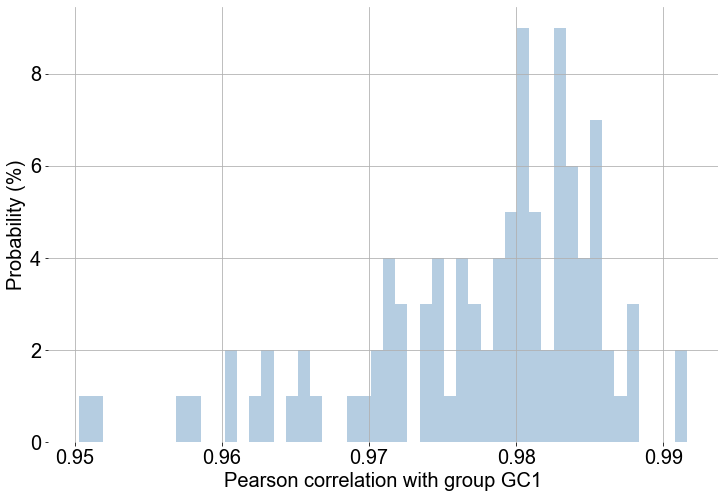

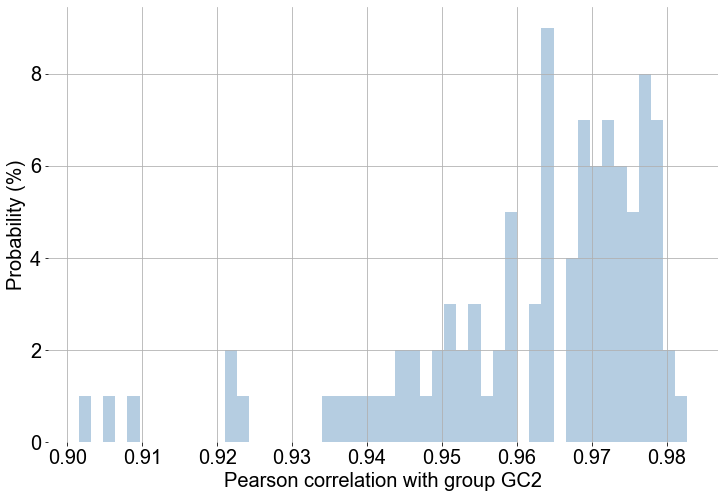

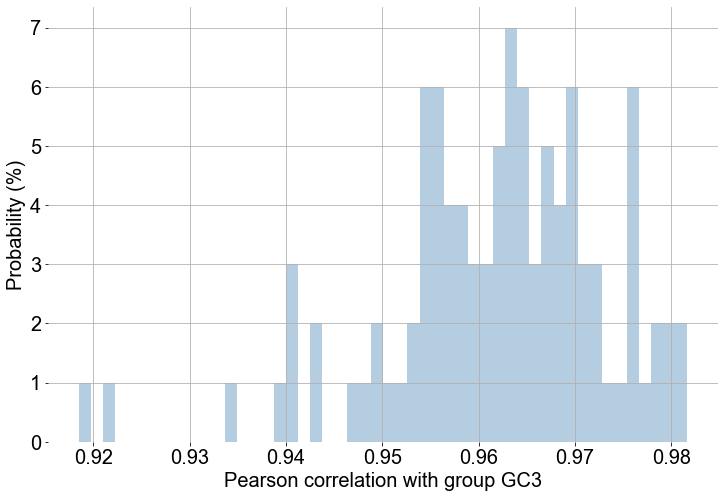

In [8]:
number = 3

indi_father = '/n02dat01/users/dyli/Grad_data/n04_data/Grad_tmp/sc_MPC_grad_indi/emb'

list_path = f'/n02dat01/users/dyli/Grad_data/support_data/HCP_U100_list.txt'
with open( list_path, 'r' ) as f:
    namelist = [ str( line.strip()) for line in f.readlines() ]
print(len(namelist))

r1 = np.zeros(len(namelist))
r2 = np.zeros(len(namelist))
r3 = np.zeros(len(namelist))
for subi,sub in enumerate(namelist):
    # calculate the correlation between the individual GCs and the group GCs
    indi_L = np.load(f'/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/{sub}_emb_L.npy')
    indi_R = np.load(f'/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/{sub}_emb_R.npy')
    r1[subi] = np.corrcoef(indi_L[:, 0:number].T, emb_L[:, 0:number].T)[0:number,:][:,number:][0,0]
    r2[subi] = np.corrcoef(indi_L[:, 0:number].T, emb_L[:, 0:number].T)[0:number,:][:,number:][1,1]
    r3[subi] = np.corrcoef(indi_L[:, 0:number].T, emb_L[:, 0:number].T)[0:number,:][:,number:][2,2]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))  #设置画布的大小
sns.set_palette("hls")       #设置所有图的颜色，使用hls色彩空间
sns.distplot(r1,color="steelblue",bins=50,norm_hist=False, kde=False)
plt.xlabel('Pearson correlation with group GC1',fontsize=20)           #添加x轴标签，并改变字体
plt.ylabel('Probability (%)',fontsize=20)   #添加y轴变浅，并改变字体
plt.grid(linestyle='-')   #添加网格线
plt.xticks(fontsize=20)   #改变x轴字体大小
plt.yticks(fontsize=20)   #改变y轴字体大小
sns.despine(ax=None, top=True, right=True, left=True,bottom=True)    #将图像的框框删掉
plt.show()

plt.figure(figsize=(12, 8))  #设置画布的大小
sns.set_palette("hls")       #设置所有图的颜色，使用hls色彩空间
sns.distplot(r2,color="steelblue",bins=50,norm_hist=False, kde=False)
plt.xlabel('Pearson correlation with group GC2',fontsize=20)           #添加x轴标签，并改变字体
plt.ylabel('Probability (%)',fontsize=20)   #添加y轴变浅，并改变字体
plt.grid(linestyle='-')   #添加网格线
plt.xticks(fontsize=20)   #改变x轴字体大小
plt.yticks(fontsize=20)   #改变y轴字体大小
sns.despine(ax=None, top=True, right=True, left=True,bottom=True)    #将图像的框框删掉
plt.show()

plt.figure(figsize=(12, 8))  #设置画布的大小
sns.set_palette("hls")       #设置所有图的颜色，使用hls色彩空间
sns.distplot(r3,color="steelblue",bins=50,norm_hist=False, kde=False)
plt.xlabel('Pearson correlation with group GC3',fontsize=20)           #添加x轴标签，并改变字体
plt.ylabel('Probability (%)',fontsize=20)   #添加y轴变浅，并改变字体
plt.grid(linestyle='-')   #添加网格线
plt.xticks(fontsize=20)   #改变x轴字体大小
plt.yticks(fontsize=20)   #改变y轴字体大小
sns.despine(ax=None, top=True, right=True, left=True,bottom=True)    #将图像的框框删掉
plt.show()

# inter-subject variability map

In [10]:
number = 3

indi_father = '/n02dat01/users/dyli/Grad_data/n04_data/Grad_tmp/sc_MPC_grad_indi/emb'

list_path = f'/n02dat01/users/dyli/Grad_data/support_data/HCP_U100_list.txt'
with open( list_path, 'r' ) as f:
    namelist = [ str( line.strip()) for line in f.readlines() ]
print(len(namelist))

def normalization(x):
    # return (x - np.min(x)) / (np.max(x) - np.min(x))
    return (x - np.min(x))

GC1_L = np.zeros((29696, 100))
GC2_L = np.zeros((29696, 100))
GC3_L = np.zeros((29696, 100))
GC1_R = np.zeros((29716, 100))
GC2_R = np.zeros((29716, 100))
GC3_R = np.zeros((29716, 100))
for subi,sub in enumerate(namelist):
    GC1_L[:, subi] = normalization(np.load(f'/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/{sub}_emb_L.npy')[:, 0])
    GC2_L[:, subi] = normalization(np.load(f'/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/{sub}_emb_L.npy')[:, 1])
    GC3_L[:, subi] = normalization(np.load(f'/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/{sub}_emb_L.npy')[:, 2])
    GC1_R[:, subi] = normalization(np.load(f'/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/{sub}_emb_R.npy')[:, 0])
    GC2_R[:, subi] = normalization(np.load(f'/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/{sub}_emb_R.npy')[:, 1])
    GC3_R[:, subi] = normalization(np.load(f'/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/{sub}_emb_R.npy')[:, 2])

100


In [ ]:
def normalization(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [8]:
intersub_var_GC1_L = np.std(GC1_L, axis=1) / np.mean(GC1_L, axis=1)
np.save('/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/intersub_var_GC1_L.npy', intersub_var_GC1_L)
intersub_var_GC2_L = np.std(GC2_L, axis=1) / np.mean(GC2_L, axis=1)
np.save('/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/intersub_var_GC2_L.npy', intersub_var_GC2_L)
intersub_var_GC3_L = np.std(GC3_L, axis=1) / np.mean(GC3_L, axis=1)
np.save('/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/intersub_var_GC3_L.npy', intersub_var_GC3_L)
intersub_var_GC1_R = np.std(GC1_R, axis=1) / np.mean(GC1_R, axis=1)
np.save('/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/intersub_var_GC1_R.npy', intersub_var_GC1_R)
intersub_var_GC2_R = np.std(GC2_R, axis=1) / np.mean(GC2_R, axis=1)
np.save('/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/intersub_var_GC2_R.npy', intersub_var_GC2_R)
intersub_var_GC3_R = np.std(GC3_R, axis=1) / np.mean(GC3_R, axis=1)
np.save('/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/intersub_var_GC3_R.npy', intersub_var_GC3_R)

# arealization for the individual

* the group arealization path
* ('/n02dat01/users/dyli/Grad_data/sc/pnas_8.dlabel.nii')

In [3]:
from utils import RGB_to_Hex, Hex_to_RGB

color_2_hex = ['#269592', '#E46F6A']
color_4_hex = ['#269592', '#5168B2', '#E46F6A', '#877ECE']
color_8_hex = ['#269592', '#B38038', '#5168B2', '#A2374B', '#877ECE', '#C6DEA3', '#F69646', '#E46F6A']
color_20_hex = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', \
                '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9', \
                '#ffffff', '#000000']

color_2_rgb = []
for hexi in range(len(color_2_hex)):
    hex_ = color_2_hex[hexi]
    color_2_rgb.append(Hex_to_RGB(hex_))
color_2_rgb = np.array(color_2_rgb)
print(color_2_rgb)

color_4_rgb = []
for hexi in range(len(color_4_hex)):
    hex_ = color_4_hex[hexi]
    color_4_rgb.append(Hex_to_RGB(hex_))
color_4_rgb = np.array(color_4_rgb)
print(color_4_rgb)

color_8_rgb = []
for hexi in range(len(color_8_hex)):
    hex_ = color_8_hex[hexi]
    color_8_rgb.append(Hex_to_RGB(hex_))
color_8_rgb = np.array(color_8_rgb)
print(color_8_rgb)

color_20_rgb = []
for hexi in range(len(color_20_hex)):
    hex_ = color_20_hex[hexi]
    color_20_rgb.append(Hex_to_RGB(hex_))
color_20_rgb = np.array(color_20_rgb)
print(color_8_rgb)

[[ 38 149 146]
 [228 111 106]]
[[ 38 149 146]
 [ 81 104 178]
 [228 111 106]
 [135 126 206]]
[[ 38 149 146]
 [179 128  56]
 [ 81 104 178]
 [162  55  75]
 [135 126 206]
 [198 222 163]
 [246 150  70]
 [228 111 106]]
[[ 38 149 146]
 [179 128  56]
 [ 81 104 178]
 [162  55  75]
 [135 126 206]
 [198 222 163]
 [246 150  70]
 [228 111 106]]


In [9]:
list_path = f'/n02dat01/users/dyli/Grad_data/support_data/HCP_U100_list.txt'
with open( list_path, 'r' ) as f:
    namelist = [ str( line.strip()) for line in f.readlines() ]
print(len(namelist))

import matplotlib as mpl
def bin2int(a: np.ndarray, b: np.ndarray, c: np.ndarray):
    data = np.concatenate([a, b, c], axis=1)
    help_arr = np.array([4, 2, 1]).T
    output = data.dot(help_arr)
    return output

for sub in tqdm(namelist):
    # indi_L = np.load(f'/n02dat01/users/dyli/Grad_data/n04_data/Grad_tmp/sc_MPC_grad_indi/emb/{sub}_MPC_sc_embedding_dense_emb_L.npy')[:, 0:number]
    # indi_R = np.load(f'/n02dat01/users/dyli/Grad_data/n04_data/Grad_tmp/sc_MPC_grad_indi/emb/{sub}_MPC_sc_embedding_dense_emb_R.npy')[:, 0:number]

    indi_L = np.load(f'/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/{sub}_emb_L.npy')
    indi_R = np.load(f'/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/{sub}_emb_R.npy')

    # 读取梯度数据
    emb = np.zeros((59412, 3))
    emb[0:29696, :] = indi_L[:, 0:3]
    emb[29696:59412, :] = indi_R[:, 0:3]

    # 进行层次聚类
    idx_G1 = np.array([0 if emb[i,0]<0 else 1 for i in range(59412)])
    idx_G2 = np.array([0 if emb[i,1]<0 else 1 for i in range(59412)])
    idx_G3 = np.array([0 if emb[i,2]<0 else 1 for i in range(59412)])

    idx = bin2int(idx_G1[:, np.newaxis], idx_G2[:, np.newaxis], idx_G3[:, np.newaxis])
    idx +=1

    # 绘制8个模块
    L_data  = np.zeros(32492)
    L_data[select_ind_L] = idx[0:29696]
    R_data = np.zeros(32492)
    R_data[select_ind_R] = idx[29696:59412]
    Data = np.concatenate([L_data, R_data])

    assert (Data >=0).all()

    pos_max = np.max(Data[Data>0])
    pos_min = np.min(Data[Data>0])
    norm_p = mpl.colors.Normalize(vmin=pos_min, vmax=pos_max)

    labelDict = {}
    for i,p in enumerate(Data):
        if p == 0:
            colorValue = (174/255, 174/255, 174/255, 1.0)
        else:
            colorValue = (color_8_rgb[int(p-1),0]/255, \
                        color_8_rgb[int(p-1),1]/255, \
                        color_8_rgb[int(p-1),2]/255, \
                        1.0)
        labelDict[p] = (i, colorValue)

    newLabelAxis = nib.cifti2.cifti2_axes.LabelAxis(['aaa'], labelDict)

    names = ['CIFTI_STRUCTURE_CORTEX_LEFT' for i in range(L_data.shape[0])]
    names.extend(['CIFTI_STRUCTURE_CORTEX_RIGHT' for i in range(R_data.shape[0])])
    verteces = [i for i in range(L_data.shape[0])]
    verteces.extend([i for i in range(L_data.shape[0])])
    brainModelAxis = nib.cifti2.cifti2_axes.BrainModelAxis(name=names, vertex=np.asarray(verteces),
                                                            nvertices={'CIFTI_STRUCTURE_CORTEX_LEFT': 32492,
                                                                        'CIFTI_STRUCTURE_CORTEX_RIGHT': 32492}, )
    newheader = nib.cifti2.cifti2.Cifti2Header.from_axes((newLabelAxis, brainModelAxis))
    newImage = nib.cifti2.cifti2.Cifti2Image(dataobj=Data.reshape([1, -1]), header=newheader)
    newImage.to_filename(f'/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/align_indi_corr_cluster/{sub}_pnas_8.dlabel.nii')

100


100%|██████████| 100/100 [01:38<00:00,  1.02it/s]


# individual atlas results: calculate ICC

In [11]:
def icc_calculate(Y, icc_type):
    
    [n, k] = Y.shape
    
    # 自由度
    dfall = n * k - 1   # 所有自由度
    dfe = (n - 1) * (k - 1)   # 剩余自由度
    dfc = k - 1    # 列自由度
    dfr = n - 1    # 行自由度
    
    # 所有的误差
    mean_Y = np.mean(Y)
    SST = ((Y - mean_Y) ** 2).sum()
    
    x = np.kron(np.eye(k), np.ones((n, 1)))  # sessions
    x0 = np.tile(np.eye(n), (k, 1))  # subjects
    X = np.hstack([x, x0])
    
    # 误差均方
    predicted_Y = np.dot(
        np.dot(np.dot(X, np.linalg.pinv(np.dot(X.T, X))), X.T), Y.flatten("F")
        )
    residuals = Y.flatten("F") - predicted_Y
    SSE = (residuals ** 2).sum()
    
    MSE = SSE / dfe
    
    # 列均方
    SSC = ((np.mean(Y, 0) - mean_Y) ** 2).sum() * n
    MSC = SSC / dfc
    
    # 行均方
    SSR = ((np.mean(Y, 1) - mean_Y) ** 2).sum() * k
    MSR = SSR / dfr

    print(f'MSR:{MSR}\nMSE:{MSE}\n')
    
    if icc_type == "icc(1)":
        SSW = SST - SSR   # 剩余均方
        MSW = SSW / (dfall - dfr)
        
        ICC1 = (MSR - MSW) / (MSR + (k - 1) * MSW)
        ICC2 = (MSR - MSW) / MSR
    
    elif icc_type == "icc(2)":
        
        ICC1 = (MSR - MSE) / (MSR + (k - 1) * MSE + k * (MSC - MSE) / n)
        ICC2 = (MSR - MSE) / (MSR +  (MSC - MSE) / n)
        
    elif icc_type == "icc(3)":
       
        ICC1 = (MSR - MSE) / (MSR + (k - 1) * MSE)
        ICC2 = (MSR - MSE) / MSR
        
    return ICC1, ICC2


In [12]:
dirc_L = f'/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = f'/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

# read the Yeo Atlas
atlas_path = '/n02dat01/users/dyli/Atlas/Schaefer2018_400Parcels_17Networks_order.dlabel.nii'
atlas = nib.load(atlas_path)
atlas_data_ = atlas.get_fdata()
atlas_data_ = np.squeeze(atlas_data_) #(64984,)
atlas_data = np.zeros(59412)
atlas_data[0:29696] = atlas_data_[select_ind_L]
atlas_data[29696:59412] = atlas_data_[select_ind_R+32492]

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [13]:
allsub_pnas8 = np.zeros((59412, 100))
for subi,sub in enumerate(namelist):
    sub_pnas8 = nib.load(f'/n02dat01/users/dyli/Grad_data/indi_GCs_alignment/align_indi_corr_cluster/{sub}_pnas_8.dlabel.nii').get_fdata()
    sub_pnas8 = np.squeeze(sub_pnas8)
    allsub_pnas8[:, subi] = np.concatenate((sub_pnas8[select_ind_L], sub_pnas8[select_ind_R+32492]), axis=0)

In [14]:
allsub_pnas8_atlas = np.array([np.sum(allsub_pnas8[atlas_data==(i+1)], axis=0)/len(np.argwhere(atlas_data==(i+1))) for i in range(400)])
allsub_pnas8_atlas = allsub_pnas8_atlas.astype(np.int16)

icc_data = allsub_pnas8_atlas

print(icc_data.shape)
icc_type = "icc(1)"
icc1, icc2 = icc_calculate(icc_data, icc_type)
print('模型{}:\t'.format(icc_type))
print('单个测量:', icc1)
print('平均测量:', icc2)
icc_type = "icc(2)"
icc1, icc2 = icc_calculate(icc_data, icc_type)
print('模型{}:\t'.format(icc_type))
print('单个测量:', icc1)
print('平均测量:', icc2)
icc_type = "icc(3)"
icc1, icc2 = icc_calculate(icc_data, icc_type)
print('模型{}:\t'.format(icc_type))
print('单个测量:', icc1)
print('平均测量:', icc2)

(400, 100)
MSR:382.0194711152882
MSE:0.536030682449271

模型icc(1):	
单个测量: 0.8734115361497754
平均测量: 0.9985527411495756
MSR:382.0194711152882
MSE:0.536030682449271

模型icc(2):	
单个测量: 0.8730780674323466
平均测量: 0.998548380780842
MSR:382.0194711152882
MSE:0.536030682449271

模型icc(3):	
单个测量: 0.8767990567948715
平均测量: 0.9985968498388724


# test

In [11]:
mpc = np.random.rand(5,5) -0.5
print(mpc)

# 去除负连接
print('remove the neg connection')
mpc[mpc<0] = 0
print(mpc)

sparse_idx=70
print(sparse_idx)
# 稀疏
# mpc = mpc.astype(np.float32)
perc_L = np.array([np.percentile(x, sparse_idx) for x in mpc])
for i in range(mpc.shape[0]):
    mpc[i, mpc[i,:] < perc_L[i]] = 0
print(mpc)

[[-1.14187401e-05  3.61477472e-01 -3.84762865e-01  1.36728973e-02
   3.58294643e-01]
 [-4.22691648e-01  2.09267759e-01 -1.36180095e-01 -2.29398287e-01
   1.50752896e-01]
 [ 1.41632613e-02 -2.80191593e-01 -2.71907600e-02  6.33706178e-03
   4.42680099e-01]
 [ 2.22625908e-01  2.83204544e-01 -1.82679151e-01  2.60740691e-01
   1.06689927e-01]
 [ 2.35938755e-01  2.43725357e-01  4.58710752e-01 -4.40339287e-01
   1.55175231e-01]]
remove the neg connection
[[0.         0.36147747 0.         0.0136729  0.35829464]
 [0.         0.20926776 0.         0.         0.1507529 ]
 [0.01416326 0.         0.         0.00633706 0.4426801 ]
 [0.22262591 0.28320454 0.         0.26074069 0.10668993]
 [0.23593876 0.24372536 0.45871075 0.         0.15517523]]
70
[[0.         0.36147747 0.         0.         0.35829464]
 [0.         0.20926776 0.         0.         0.1507529 ]
 [0.01416326 0.         0.         0.         0.4426801 ]
 [0.         0.28320454 0.         0.26074069 0.        ]
 [0.         0.2437253